# GLM @ KTH with If Insurance
This is a code template for project 2 in the course SF2930 regression Analysis

* Questions regarding this lab can be sent to Lovisa, Ingrid or Oscar from If (contact information on Canvas)
* Questions regarding the report are referred to the course resposibles from KTH's side.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import glm
import re

# Read data
* Provided data in Cancellation.csv is read into a table
* Note that the folder in which you have Cancellation.csv must be set as the working directory
* You don't need to change anything in this section

In [2]:
df = pd.read_csv(
    r"Cancellation.csv",
    sep=",",
    decimal=".",
)

In [3]:
# Initial check on number of rows and columns
n_rows = df.shape[0]
n_columns = df.shape[1]
print(f"Number iof rows: {n_rows}\nNumber of columns: {n_columns}")

Number iof rows: 81708
Number of columns: 10


In [4]:
# Initial display of the data frame
df
print(sum(df["ClaimCost"]))

nan


# Exploration
* Check distribution of average claim size and number of claims
* Check if claim cost and number of claims vary between risk years

In [5]:
df["AvgClaimCost"] = df["ClaimCost"] / df["NumberOfClaims"]



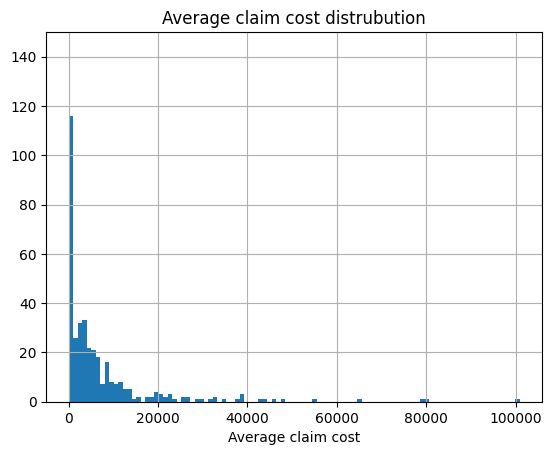

In [6]:
df["AvgClaimCost"].hist(bins=100)
plt.ylim((0, 150))  # limit y-axis due to high density at 0
plt.xlabel("Average claim cost")
plt.title("Average claim cost distrubution")
plt.show()

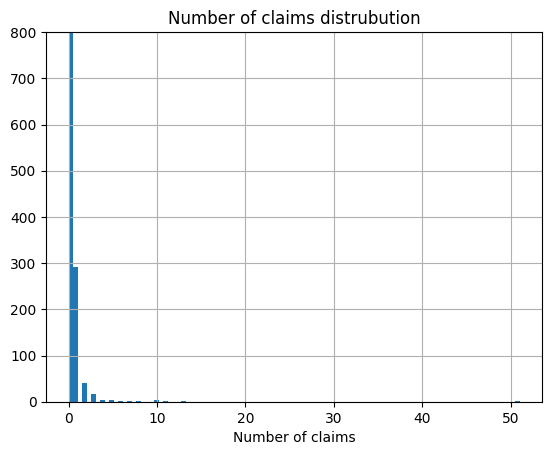

In [7]:
df["NumberOfClaims"].hist(bins=100)
plt.ylim((0, 800))  # limit y-axis due to high density at 0
plt.xlabel("Number of claims")
plt.title("Number of claims distrubution")
plt.show()

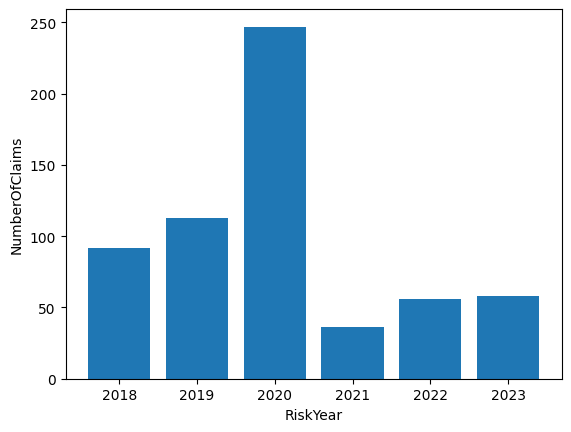

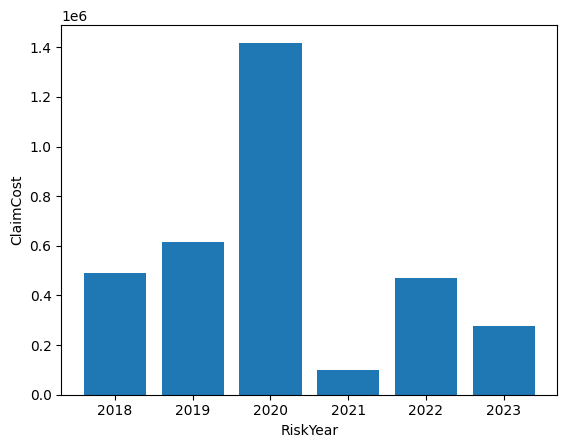

In [8]:
# Aggregate per RiskYear to see development over time
agg_dict = {"NumberOfClaims": "sum", "ClaimCost": "sum"}
df_agg_ry = df.groupby("RiskYear").agg(agg_dict)

for var in agg_dict:
    plt.bar(df_agg_ry.index, df_agg_ry[var])
    plt.xlabel(df_agg_ry.index.name)
    plt.ylabel(var)
    plt.show()

# Preprocess data
Now you need to modify your data so that you can perform a GLM analysis.

1. Missing values need to be handeled
2. Any continuous variable you want to use needs to be grouped into discrete groups
3. Categorical variables can be grouped even more

Below, there are examples on how to handle missing variables, how to group numerical variables and how to group categorical varaibles further.

### Handle missing values
If some variables are missing data for some rows, how do we handle this? Some alternatives:
* Make a "missing" group
* Fill numerical values with mean or median
* Fill with most common value

In [9]:
# Determine the most common value of Dangerous Area or not
danCount  = df['DangerousAreas'].value_counts()
danResult = "Excluded" if danCount.get("Excluded", 0) >= danCount.get("Not excluded", 0) else "Not excluded"

areaCount  = df['TravellingArea'].value_counts()


fill_missing_with = {
    "ActivityCode" : "X",
    "ClaimCost" : 0,
    "CompanyAge" : np.mean(df["CompanyAge"]), # assume average age
    "DangerousAreas" : danResult, # most common answer
    "Duration" : np.mean(df["Duration"]),
    "FinancialRating" : "IR", # its own category - ir means information is missing (make a missing group)
    "NumberOfPersons" : round(np.mean(df["NumberOfPersons"])), # assume average many employees
    "NumberOfClaims" : np.median(df["NumberOfClaims"]),
    "RiskYear" : "year unknown",
    "TravellingArea" : areaCount.index[0] # most common area
}

for var in fill_missing_with:
    df.loc[df[var].isna(), var] = fill_missing_with[var]



C:\Users\ville\AppData\Local\Temp\ipykernel_13668\3396154755.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'year unknown' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[var].isna(), var] = fill_missing_with[var]


## Grouping
The groupings below are only examples, you need to create your own groups, with breaks that suit your data.

For example visualize the data for the different variables and refer to the information in the Appendix group the Activity codes on similar types of business.

Remember to think about risk homogeneous and stable groups, for example having groups with zero number of caims or claims cost and almost no Duration makes it hard to determine its risk.

You might also want to group other variables from glmdata, in a similar manner

### Group numerical variables
When grouping numerical variables we can specify the group edges and labels, and then let pandas cut()-function do the job.

It is important that there are claims and claim cost in each resulting group. Therefore it is always a good idea to check some statistics after doing the grouping.

In [10]:
# Define the variable that is going to be grouped, the name of the new (grouped) variable, group/bin edges and labels
variable1 = "CompanyAge"
grouped_variable_name1 = "CompanyAgeGroup"
bin_edges = [-np.inf, 4, 10, 15, 25, np.inf]
bin_labels = ["01. <=3", "02. 4-10", "03. 10-15", "04. 15-25", "05. >=25"]

# This part does the grouping based on the input above
df[grouped_variable_name1] = pd.cut(
    df[variable1],
    bins=bin_edges,
    labels=bin_labels,
    right=False)  # Wheter to include the right edge in group or not



# # DURATION
# variable = "Duration"
# grouped_variable_name = "DurationGroup"
# bin_edges = [-np.inf, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1.5]
# bin_labels = ["01. <1", "02. 1-3", "03. 3-8", "04. 8-15", "05. 15-30", "06. >=30"]
# df[grouped_variable_name] = pd.cut(
#     df[variable],
#     bins=bin_edges,
#     labels=bin_labels,
#     right=False,  # Wheter to include the right edge in group or not
# )




# NoP
variable2 = "NumberOfPersons"
grouped_variable_name2 = "NoPGroup"
bin_edges = [-np.inf, 3,10,40,100,500,1500, np.inf]
bin_labels = ["01. <=3", "02. 4-10", "03. 11-40", "04. 41-100", "05. 101-500", "06. 501-1500", "07. >1500"]


# This part does the grouping based on the input above
df[grouped_variable_name2] = pd.cut(
    df[variable2],
    bins=bin_edges,
    labels=bin_labels,
    right=True ) # Whether to include the right edge in group or not)














#### Check on the resulting groups
- Make sure there are claims in each group
- Plot frequency, severity, claim cost and duration per group to see the marginal factors and how much duration we have in each group

In [11]:
# How to aggregate the data to see how many rows, claims and how much claim cost there is in each category
aggregations1 = {
    "Duration": "sum",
    "NumberOfClaims": "sum",
    "ClaimCost": "sum",
}

# Do the aggregation and renamning
df_agg_stat1 = (
    df.groupby(grouped_variable_name1).agg(aggregations1)
)


# How to aggregate the data to see how many rows, claims and how much claim cost there is in each category
aggregations2 = {
    "Duration": "sum",
    "NumberOfClaims": "sum",
    "ClaimCost": "sum",
}

# Do the aggregation and renamning
df_agg_stat2 = (
    df.groupby(grouped_variable_name2).agg(aggregations2)
)

# Display the aggregated data
print(df_agg_stat1)
#print(df_agg_stat2)

                   Duration  NumberOfClaims     ClaimCost
CompanyAgeGroup                                          
01. <=3          15493.6633              61  2.537902e+05
02. 4-10         18016.5391              78  8.083716e+05
03. 10-15        11100.2243              70  4.429415e+05
04. 15-25        10733.8687              98  4.989391e+05
05. >=25         14026.4427             295  1.369361e+06


C:\Users\ville\AppData\Local\Temp\ipykernel_13668\1458235738.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(grouped_variable_name1).agg(aggregations1)
C:\Users\ville\AppData\Local\Temp\ipykernel_13668\1458235738.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(grouped_variable_name2).agg(aggregations2)


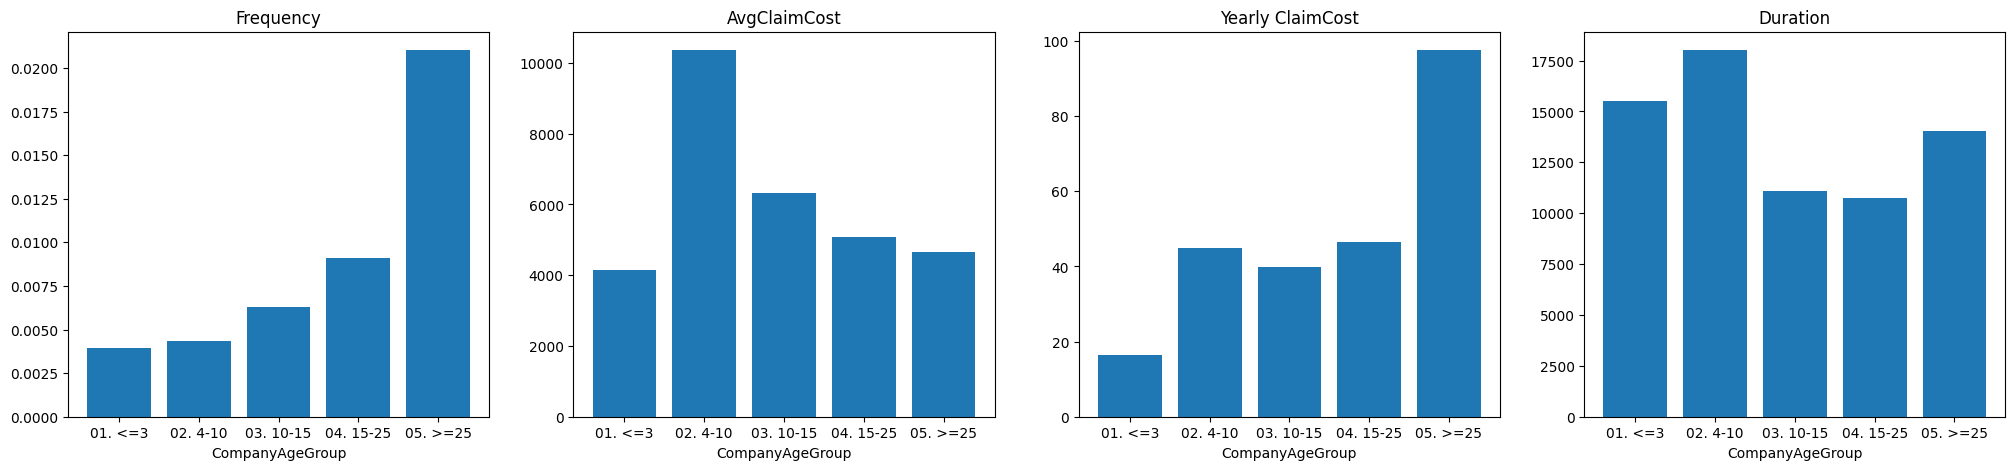

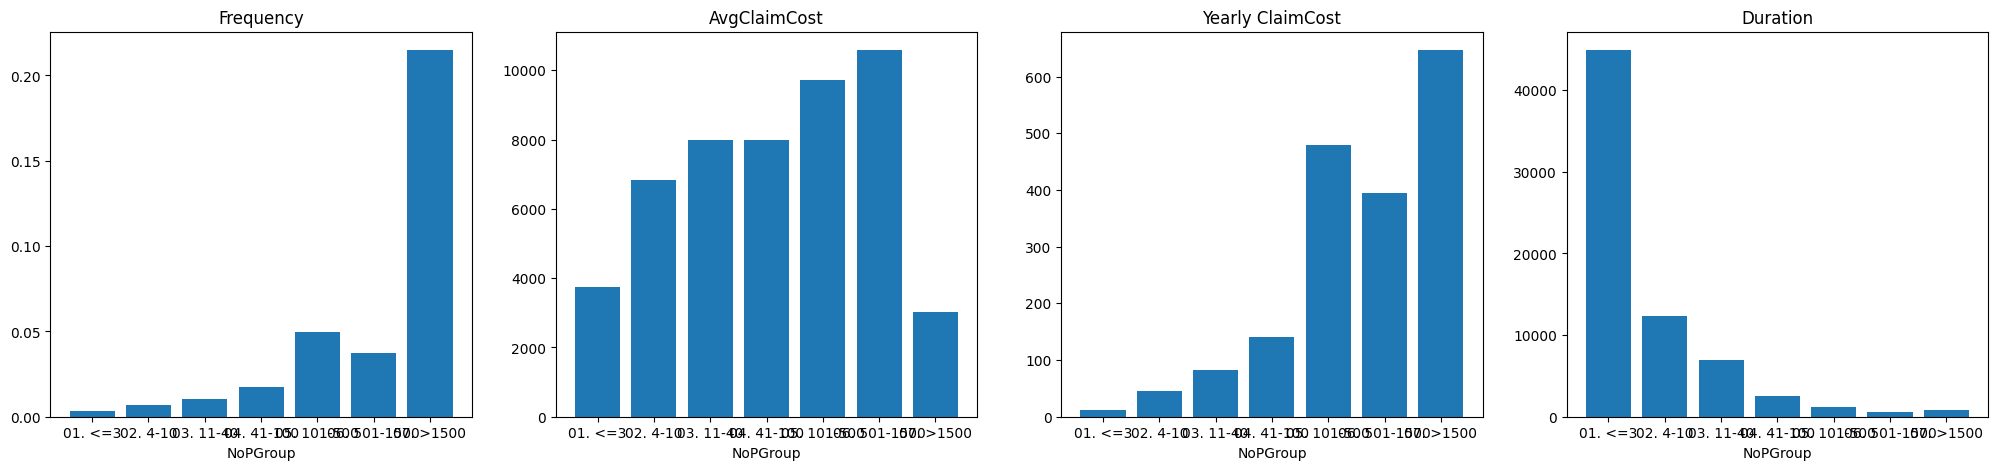

In [12]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat1.index.name)
plt.bar(df_agg_stat1.index, df_agg_stat1["NumberOfClaims"] / df_agg_stat1["Duration"])
plt.title("Frequency")

plt.subplot(142)
plt.xlabel(df_agg_stat1.index.name)
plt.bar(df_agg_stat1.index, df_agg_stat1["ClaimCost"] / df_agg_stat1["NumberOfClaims"])
plt.title("AvgClaimCost")

plt.subplot(143)
plt.xlabel(df_agg_stat1.index.name)
plt.bar(df_agg_stat1.index, df_agg_stat1["ClaimCost"] / df_agg_stat1["Duration"])
plt.title("Yearly ClaimCost")

plt.subplot(144)
plt.xlabel(df_agg_stat1.index.name)
plt.bar(df_agg_stat1.index, df_agg_stat1["Duration"])
plt.title("Duration")




fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat2.index.name)
plt.bar(df_agg_stat2.index, df_agg_stat2["NumberOfClaims"] / df_agg_stat2["Duration"])
plt.title("Frequency")

plt.subplot(142)
plt.xlabel(df_agg_stat2.index.name)
plt.bar(df_agg_stat2.index, df_agg_stat2["ClaimCost"] / df_agg_stat2["NumberOfClaims"])
plt.title("AvgClaimCost")

plt.subplot(143)
plt.xlabel(df_agg_stat2.index.name)
plt.bar(df_agg_stat2.index, df_agg_stat2["ClaimCost"] / df_agg_stat2["Duration"])
plt.title("Yearly ClaimCost")

plt.subplot(144)
plt.xlabel(df_agg_stat2.index.name)
plt.bar(df_agg_stat2.index, df_agg_stat2["Duration"])
plt.title("Duration")




plt.show()

### Group categorical variables
When grouping categorical variables we can for each current category specify the new category, and then let pandas replace()-function do the job.

As for numerical variables, it is important that there are claims and claim cost in each resulting group. Therefore it is always a good idea to check some statistics after doing the grouping.

In [13]:
# Define the variable that is going to be grouped, the name of the new (grouped) variable and grouping map
variable3 = "ActivityCode"
grouped_variable_name3 = "ActivityGroup"

""" Industry, Service, Other, Engineering, Government, Missing"""

# grouping_map structure: {current category : new category}
grouping_map3 = {
    "A": "Industry",
    "B": "Engineering",
    "C": "Industry",
    "D": "Industry",
    "E": "Engineering",
    "F": "Engineering",
    "G": "Other",
    "H": "Industry",
    "I": "Service",
    "J": "Service",
    "K": "Other",
    "L": "Other",
    "M": "Other",
    "N": "Other",
    "O": "Government",
    "P": "Government",
    "Q": "Government",
    "R": "Other",
    "S": "Service",
    "T": "Service",
    "U": "Engineering",
    "X": "Missing",
}

# This part does the grouping based on the input above
df[grouped_variable_name3] = df[variable3].replace(to_replace=grouping_map3)





#### Check on the resulting groups
- Make sure there are claims in each group
- Plot frequency, severity, claim cost and duration per group to see the marginal factors and how much duration we have in each group

In [14]:
# How to aggregate the data to see how many rows, claims and how much claim cost there is in each category
aggregations3 = {
    "Duration": "sum",
    "NumberOfClaims": "sum",
    "ClaimCost": "sum",
}

# Do the aggregation and renamning
df_agg_stat3 = (
    df.groupby(grouped_variable_name3).agg(aggregations3)
)

# Display the aggregated data
print(df_agg_stat3)

                 Duration  NumberOfClaims     ClaimCost
ActivityGroup                                          
Engineering     7134.5522              28  1.435429e+05
Government      4014.5291              71  2.862229e+05
Industry        7826.4581             117  2.958925e+05
Missing          666.0512               5  4.009675e+03
Other          37660.6910             258  1.978019e+06
Service        12068.4565             123  6.657166e+05


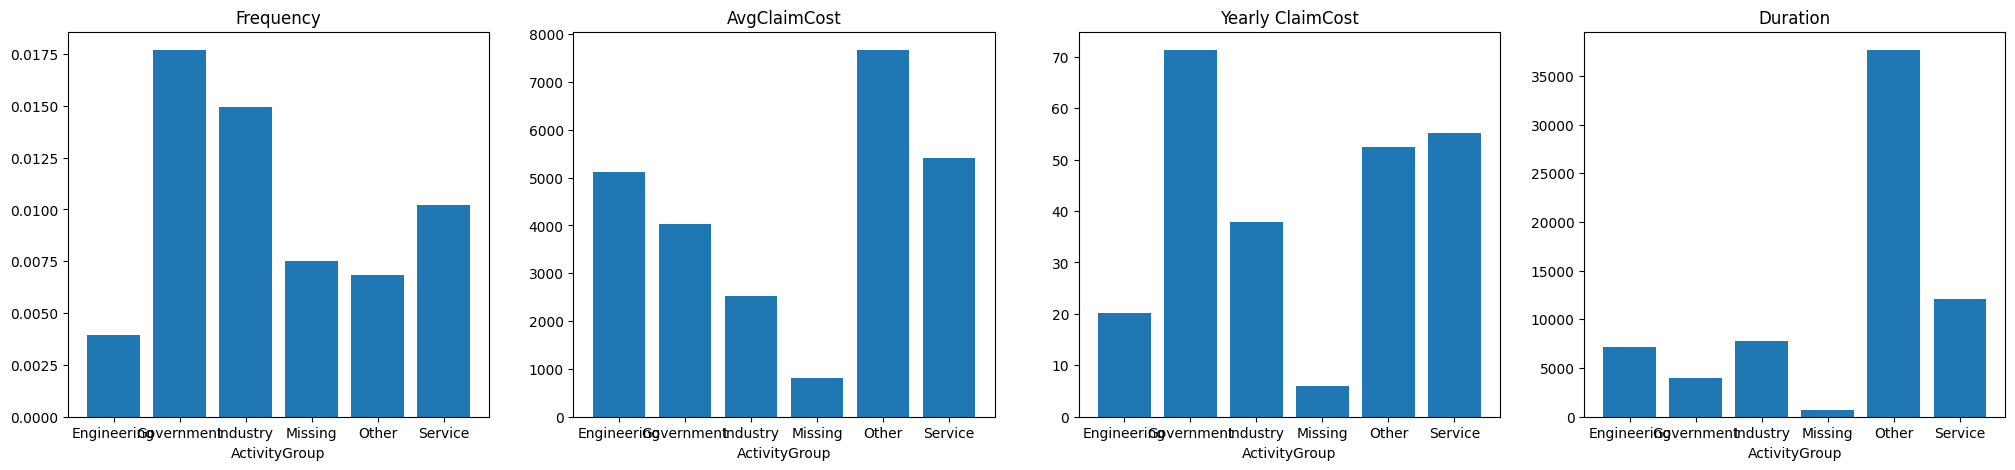

In [15]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel(df_agg_stat3.index.name)
plt.bar(df_agg_stat3.index, df_agg_stat3["NumberOfClaims"] / df_agg_stat3["Duration"])
plt.title("Frequency")

plt.subplot(142)
plt.xlabel(df_agg_stat3.index.name)
plt.bar(df_agg_stat3.index, df_agg_stat3["ClaimCost"] / df_agg_stat3["NumberOfClaims"])
plt.title("AvgClaimCost")

plt.subplot(143)
plt.xlabel(df_agg_stat3.index.name)
plt.bar(df_agg_stat3.index, df_agg_stat3["ClaimCost"] / df_agg_stat3["Duration"])
plt.title("Yearly ClaimCost")

plt.subplot(144)
plt.xlabel(df_agg_stat3.index.name)
plt.bar(df_agg_stat3.index, df_agg_stat3["Duration"])
plt.title("Duration")

plt.show()

## Aggregate data and calculate avereage claim cost within each tariff cell

Secondly, we want to aggregate the data. That is, instead of having one row per company & year, we want one row for each existing combination of variables, that is, one row for each tariff cell.

This code aggregates columns for Duration, # of Claims & ClaimCost, by two variables: NoPGroup and ActivityGroup

The aggregated data is stored in a new table, df_agg

You need to consider if there are any other variables you want to aggregate by, and modify the code accordingly

In [16]:
variables = ["ActivityGroup", "NoPGroup", "CompanyAgeGroup"]  # The varaibles to use in the model
variablesMORE = ["ActivityGroup", "NoPGroup", "CompanyAgeGroup", "DangerousAreas", "TravellingArea", "FinancialRating"]  # More varaibles to use in the model


df_agg = (
    df[variables + ["Duration", "NumberOfClaims", "ClaimCost"]]
    .groupby(variables)
    .agg("sum")
    .reset_index()
)  # Aggregation to tariff cells



df_aggMORE = (
    df[variablesMORE + ["Duration", "NumberOfClaims", "ClaimCost"]]
    .groupby(variablesMORE)
    .agg("sum")
    .reset_index()
)  # Aggregation to tariff cells

#print(df_agg)
#print(df_aggMORE)

C:\Users\ville\AppData\Local\Temp\ipykernel_13668\2133787452.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(variables)
C:\Users\ville\AppData\Local\Temp\ipykernel_13668\2133787452.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(variablesMORE)


In [17]:
# Calculating the average claim cost within each tariff cell
df_agg["AvgClaimCost"] = df_agg["ClaimCost"] / df_agg["NumberOfClaims"]
df_aggMORE["AvgClaimCost"] = df_aggMORE["ClaimCost"] / df_aggMORE["NumberOfClaims"]

In [18]:
df_agg  # Display aggregated dataframe
##df_aggMORE

,ActivityGroup,NoPGroup,CompanyAgeGroup,Duration,NumberOfClaims,ClaimCost,AvgClaimCost
0,Engineering,01. <=3,01. <=3,1660.5433,0,0.000000,NaN
1,Engineering,01. <=3,02. 4-10,1230.1701,2,1977.902592,988.951296
2,Engineering,01. <=3,03. 10-15,684.9408,1,3839.392653,3839.392653
3,Engineering,01. <=3,04. 15-25,450.7317,1,10189.485374,10189.485374
4,Engineering,01. <=3,05. >=25,385.7403,0,0.000000,NaN
...,...,...,...,...,...,...,...
205,Service,07. >1500,01. <=3,0.0000,0,0.000000,NaN
206,Service,07. >1500,02. 4-10,0.0000,0,0.000000,NaN
207,Service,07. >1500,03. 10-15,3.4142,0,0.000000,NaN
208,Service,07. >1500,04. 15-25,0.0000,0,0.000000,NaN


# GLM analysis
Now we get to the fun part - the GLM analysis

First we have some helping functions
* run_glm: takes in data, formula (target variable ~ variable1 + variable2 + ...), distribution and possible exposure or weight
* get_model_coefficients: takes in model and variable for which we want the model factors and the confidence intervals
* plot_model_results: uses get_model_coefficients to plot factors and confidence intervals

Then we run frequency model and severity model separately. Remember to use the same variables in both models.

In [19]:
# Function for running glm using statsmodels glm-function
def run_glm(df, formula, family, exposure_col=None, weight_col=None):
    exposure = df[exposure_col] if exposure_col is not None else None
    weight = df[weight_col] if weight_col is not None else None
    model = glm(
        formula=formula,
        data=df,
        family=family,
        exposure=exposure,
        var_weights=weight,
        missing="raise",
    ).fit()
    return model

In [20]:
def get_model_coefficients(model, col_name, confidence_alpha=0.05):
    """Get coefficients from categorical variables"""
    coefs = np.exp(model.params[model.params.index.str.contains(col_name)])

    ref = coefs.index[-1]
    ref = re.sub(r".*?[\=]", "", ref, 1)
    ref = re.sub(r"[\)].*", "", ref)[1:-1]

    coefs.index = (
        coefs.index.str.replace(".*[\)]", "", regex=True)
        .str.replace("T.", "", regex=False)
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
    )
    coefs = pd.concat([coefs,pd.Series([1], index=[ref])]).sort_index()

    conf_int = np.exp(
        model.conf_int(alpha=confidence_alpha, cols=None)[
            model.params.index.str.contains(col_name)
        ]
    )
    conf_int.index = (
        conf_int.index.str.replace(".*[\)]", "", regex=True)
        .str.replace("T.", "", regex=False)
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
    )
    lower = pd.concat([conf_int[0],pd.Series([1], index=[ref])]).sort_index()
    upper = pd.concat([conf_int[1],pd.Series([1], index=[ref])]).sort_index()

    return coefs, lower, upper


def plot_model_result(
    model, variable, model_type_name, conf_int=True, fig_size=(8, 8), return_fig=False
):
    coefs, lower, upper = get_model_coefficients(model, variable)

    fig = plt.figure(figsize=fig_size)
    plt.plot(coefs.index, coefs, label="risk")
    if conf_int:
        plt.plot(lower.index, lower, "g:", label="lower cofidence bound")
        plt.plot(upper.index, upper, "g:", label="upper confidence bound")
        plt.ylim(0, np.max(upper) + 0.1)
    plt.hlines(1, coefs.index[0], coefs.index[-1], linestyle="dotted", color="black")
    plt.xlabel(variable)
    plt.ylabel("Relative risk")
    plt.title(f"{model_type_name} factors for {variable}")
    plt.legend()
    if return_fig:
        return fig

<>:10: SyntaxWarning: invalid escape sequence '\)'
<>:23: SyntaxWarning: invalid escape sequence '\)'
<>:10: SyntaxWarning: invalid escape sequence '\)'
<>:23: SyntaxWarning: invalid escape sequence '\)'
C:\Users\ville\AppData\Local\Temp\ipykernel_13668\3538974065.py:10: SyntaxWarning: invalid escape sequence '\)'
  coefs.index.str.replace(".*[\)]", "", regex=True)
C:\Users\ville\AppData\Local\Temp\ipykernel_13668\3538974065.py:23: SyntaxWarning: invalid escape sequence '\)'
  conf_int.index.str.replace(".*[\)]", "", regex=True)


## Frequency model
Here we use the Poisson distribution, NumberOfClaims as target and Duration as exposure measure to get the frequency

### Formula
The formula is on the form 'target variable ~ C(variable1,Treatment(reference="group name")) + ... '. As a starting point, the reference group can be chosen as the one with most duartion.

In [21]:
frequency_formula = 'NumberOfClaims ~ C(NoPGroup,Treatment(reference="01. <=3")) + C(CompanyAgeGroup,Treatment(reference="01. <=3")) +  C(ActivityGroup,Treatment(reference="Other"))'
frequency_family = (
    sm.families.Poisson()
)  # For frequency model we use poisson distribution

frequency_model = run_glm(
    df_agg[df_agg["Duration"]>0],
    frequency_formula,
    frequency_family,
    exposure_col="Duration",  # To get everything on yearly basis, we use Duration as exposure measure
)

frequency_formulaMORE = 'NumberOfClaims ~ C(NoPGroup,Treatment(reference="01. <=3")) + C(CompanyAgeGroup,Treatment(reference="02. 4-10")) +  C(ActivityGroup,Treatment(reference="Other"))+ C(DangerousAreas,Treatment(reference="Excluded"))+ C(TravellingArea,Treatment(reference="Whole world")) + C(FinancialRating,Treatment(reference="AA"))'

frequency_familyMORE = (
    sm.families.Poisson()
)  # For frequency model we use poisson distribution

frequency_modelMORE = run_glm(
    df_aggMORE[df_aggMORE["Duration"]>0],
    frequency_formulaMORE,
    frequency_familyMORE,
    exposure_col="Duration",  # To get everything on yearly basis, we use Duration as exposure measure
)

In [22]:
# Display model summary
frequency_model.summary()

frequency_modelMORE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         NumberOfClaims   No. Observations:                 1917
Model:                            GLM   Df Residuals:                     1891
Model Family:                 Poisson   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -973.38
Date:                Mon, 18 Mar 2024   Deviance:                       1401.9
Time:                        14:34:16   Pearson chi2:                 5.30e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5559
Covariance Type:            nonrobust                                         
=============================================================================================================================================
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    -5.3075      0.148    -35.841      0.000      -5.598      -5.017
C(NoPGroup, Treatment(reference="01. <=3"))[T.02. 4-10]                       0.4996      0.143      3.487      0.000       0.219       0.780
C(NoPGroup, Treatment(reference="01. <=3"))[T.03. 11-40]                      0.7729      0.155      4.998      0.000       0.470       1.076
C(NoPGroup, Treatment(reference="01. <=3"))[T.04. 41-100]                     1.3005      0.182      7.156      0.000       0.944       1.657
C(NoPGroup, Treatment(reference="01. <=3"))[T.05. 101-500]                    2.2713      0.172     13.183      0.000       1.934       2.609
C(NoPGroup, Treatment(reference="01. <=3"))[T.06. 501-1500]                   2.6340      0.256     10.280      0.000       2.132       3.136
C(NoPGroup, Treatment(reference="01. <=3"))[T.07. >1500]                      4.6300      0.161     28.700      0.000       4.314       4.946
C(CompanyAgeGroup, Treatment(reference="02. 4-10"))[T.01. <=3]                0.3894      0.193      2.014      0.044       0.010       0.768
C(CompanyAgeGroup, Treatment(reference="02. 4-10"))[T.03. 10-15]              0.2383      0.170      1.403      0.161      -0.094       0.571
C(CompanyAgeGroup, Treatment(reference="02. 4-10"))[T.04. 15-25]              0.2415      0.159      1.521      0.128      -0.070       0.553
C(CompanyAgeGroup, Treatment(reference="02. 4-10"))[T.05. >=25]               0.2891      0.149      1.938      0.053      -0.003       0.581
C(ActivityGroup, Treatment(reference="Other"))[T.Engineering]                -1.2959      0.217     -5.978      0.000      -1.721      -0.871
C(ActivityGroup, Treatment(reference="Other"))[T.Government]                 -0.7189      0.204     -3.532      0.000      -1.118      -0.320
C(ActivityGroup, Treatment(reference="Other"))[T.Industry]                   -0.3770      0.123     -3.073      0.002      -0.617      -0.137
C(ActivityGroup, Treatment(reference="Other"))[T.Missing]                    -0.9760      0.456     -2.141      0.032      -1.870      -0.082
C(ActivityGroup, Treatment(reference="Other"))[T.Service]                     0.1943      0.111      1.743      0.081      -0.024       0.413
C(DangerousAreas, Treatment(reference="Excluded"))[T.Not Excluded]            1.0694      0.215      4.967      0.000       0.647       1.491
C(TravellingArea, Treatment(reference="Whole world"))[T.Europe]              -0.3096      0.238     -1.301      0.193      -0.776       0.157
C(TravellingArea, Treatment(reference="Whole world"))[T.Nordic countries]    -1.6650      0.581     -

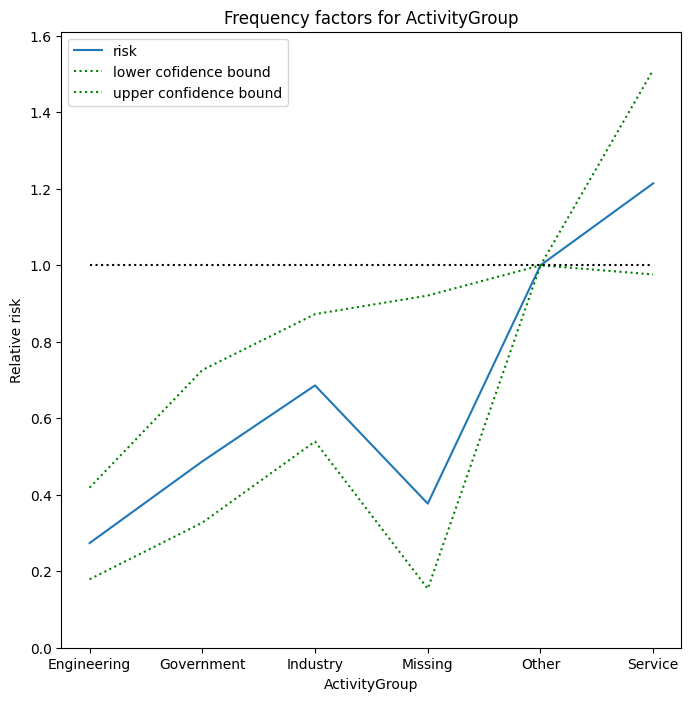

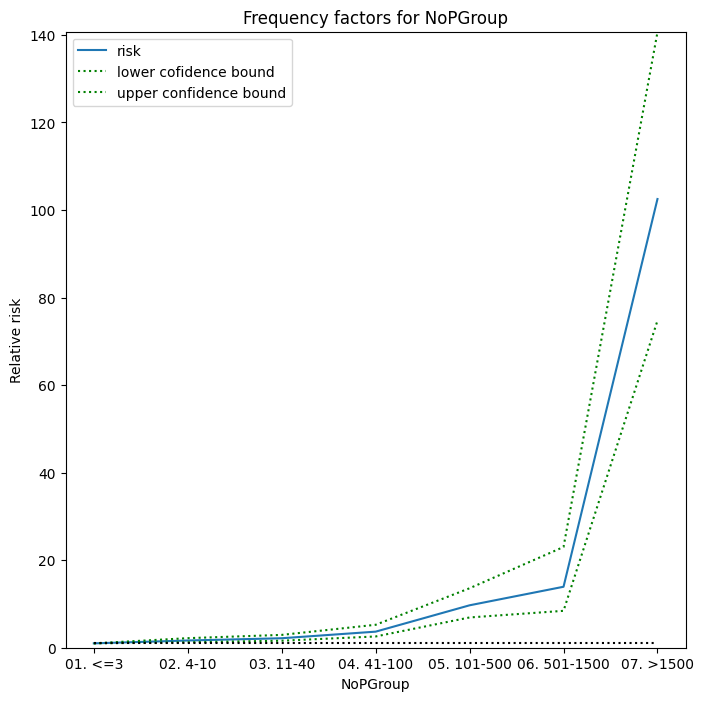

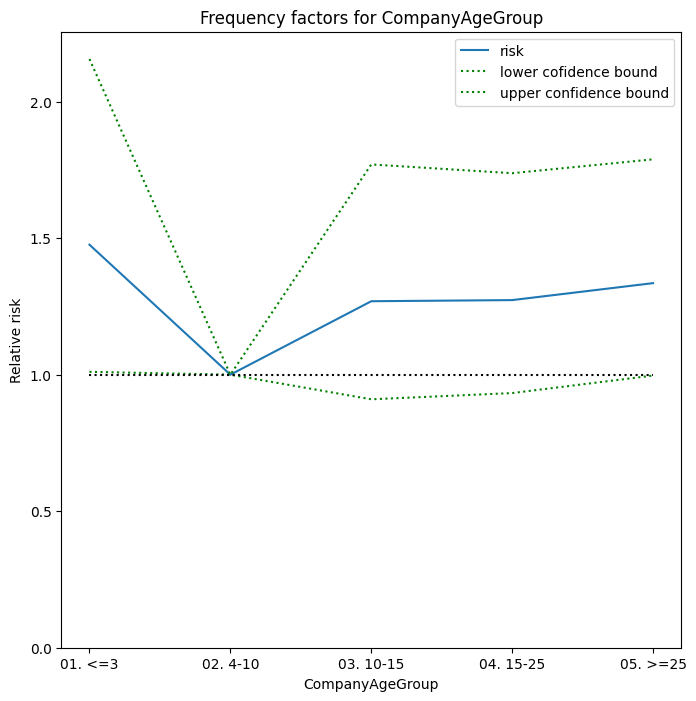

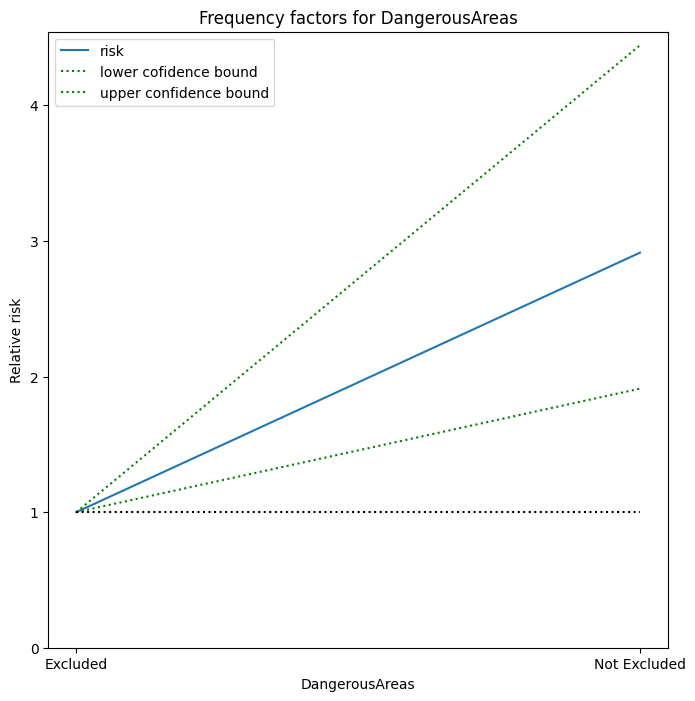

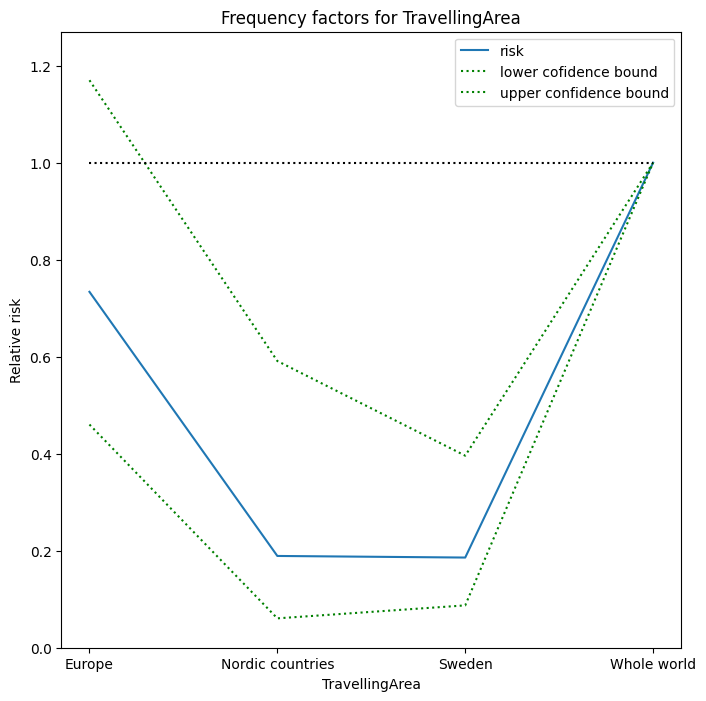

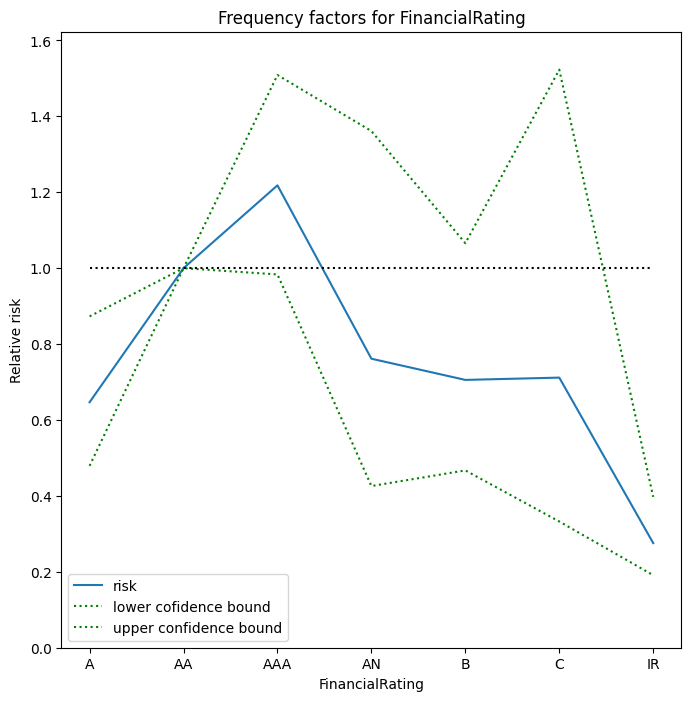

In [23]:
# Plot model factors and confidence intervals
for var in variablesMORE:
    coefs = get_model_coefficients(frequency_modelMORE, var)[0]
    coefs.index.name = var
    coefs_df = pd.DataFrame(coefs, columns=[f"{var}_frequency_factor"])
    df = df.merge(coefs_df, on=var)

    plot_model_result(frequency_modelMORE, var, "Frequency")

## Severity model
Here we use the Gamma distribution with a log link, average claim cost as target and number of claims as weight

In [24]:
severity_formula = 'AvgClaimCost ~ C(NoPGroup,Treatment(reference="01. <=3")) + C(CompanyAgeGroup,Treatment(reference="02. 4-10")) +  C(ActivityGroup,Treatment(reference="Other"))'

severity_formulaMORE = 'AvgClaimCost ~ C(NoPGroup,Treatment(reference="01. <=3")) + C(CompanyAgeGroup,Treatment(reference="02. 4-10")) +  C(ActivityGroup,Treatment(reference="Other"))+ C(DangerousAreas,Treatment(reference="Excluded"))+ C(TravellingArea,Treatment(reference="Whole world"))+C(FinancialRating,Treatment(reference="AA"))'
link = sm.genmod.families.links.log()
severity_family = sm.families.Gamma(link=link)  # For severity model we use

severity_model = run_glm(
    df_agg[df_agg["AvgClaimCost"] > 0],
    severity_formula,
    severity_family,
    weight_col="NumberOfClaims",  # For additional aggregation done by the model, the average number of claims need to be weighted by number of claims.
)

severity_modelMORE = run_glm(
    df_aggMORE[df_aggMORE["AvgClaimCost"] > 0],
    severity_formulaMORE,
    severity_family,
    weight_col="NumberOfClaims",  # For additional aggregation done by the model, the average number of claims need to be weighted by number of claims.
)

c:\Users\ville\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [25]:
severity_model.summary()
severity_modelMORE.summary()
# for var in variablesMORE:
#     coefsSev = get_model_coefficients(severity_modelMORE, var)[0]
#     coefsFre = get_model_coefficients(frequency_modelMORE, var)[0]
    
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AvgClaimCost   No. Observations:                  169
Model:                            GLM   Df Residuals:                      144
Model Family:                   Gamma   Df Model:                           24
Link Function:                    log   Scale:                          2.4404
Method:                          IRLS   Log-Likelihood:                -1703.9
Date:                Mon, 18 Mar 2024   Deviance:                       301.24
Time:                        14:34:19   Pearson chi2:                     351.
No. Iterations:                    61   Pseudo R-squ. (CS):             0.4377
Covariance Type:            nonrobust                                         
=============================================================================================================================================
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     8.7537      0.255     34.271      0.000       8.253       9.254
C(NoPGroup, Treatment(reference="01. <=3"))[T.02. 4-10]                       0.8292      0.251      3.309      0.001       0.338       1.320
C(NoPGroup, Treatment(reference="01. <=3"))[T.03. 11-40]                      0.9155      0.260      3.520      0.000       0.406       1.425
C(NoPGroup, Treatment(reference="01. <=3"))[T.04. 41-100]                     0.8624      0.320      2.696      0.007       0.235       1.489
C(NoPGroup, Treatment(reference="01. <=3"))[T.05. 101-500]                    0.9204      0.277      3.324      0.001       0.378       1.463
C(NoPGroup, Treatment(reference="01. <=3"))[T.06. 501-1500]                   0.9411      0.435      2.163      0.031       0.088       1.794
C(NoPGroup, Treatment(reference="01. <=3"))[T.07. >1500]                      0.0131      0.242      0.054      0.957      -0.461       0.487
C(CompanyAgeGroup, Treatment(reference="02. 4-10"))[T.01. <=3]               -0.6436      0.346     -1.858      0.063      -1.322       0.035
C(CompanyAgeGroup, Treatment(reference="02. 4-10"))[T.03. 10-15]             -0.1864      0.302     -0.618      0.537      -0.778       0.405
C(CompanyAgeGroup, Treatment(reference="02. 4-10"))[T.04. 15-25]             -0.7438      0.295     -2.524      0.012      -1.321      -0.166
C(CompanyAgeGroup, Treatment(reference="02. 4-10"))[T.05. >=25]              -0.5527      0.270     -2.044      0.041      -1.083      -0.023
C(ActivityGroup, Treatment(reference="Other"))[T.Engineering]                 0.0786      0.454      0.173      0.863      -0.812       0.969
C(ActivityGroup, Treatment(reference="Other"))[T.Government]                 -0.1600      0.258     -0.620      0.535      -0.665       0.345
C(ActivityGroup, Treatment(reference="Other"))[T.Industry]                   -0.7969      0.233     -3.420      0.001      -1.254      -0.340
C(ActivityGroup, Treatment(reference="Other"))[T.Missing]                    -1.1087      1.184     -0.937      0.349      -3.429       1.212
C(ActivityGroup, Treatment(reference="Other"))[T.Service]                    -0.3502      0.193     -1.812      0.070      -0.729       0.029
C(DangerousAreas, Treatment(reference="Excluded"))[T.Not Excluded]           -0.1944      0.393     -0.495      0.620      -0.964       0.575
C(TravellingArea, Treatment(reference="Whole world"))[T.Europe]               0.4759      0.467      1.019      0.308      -0.440       1.391
C(TravellingArea, Treatment(reference="Whole world"))[T.Nordic countries]     0.4998      0.943      

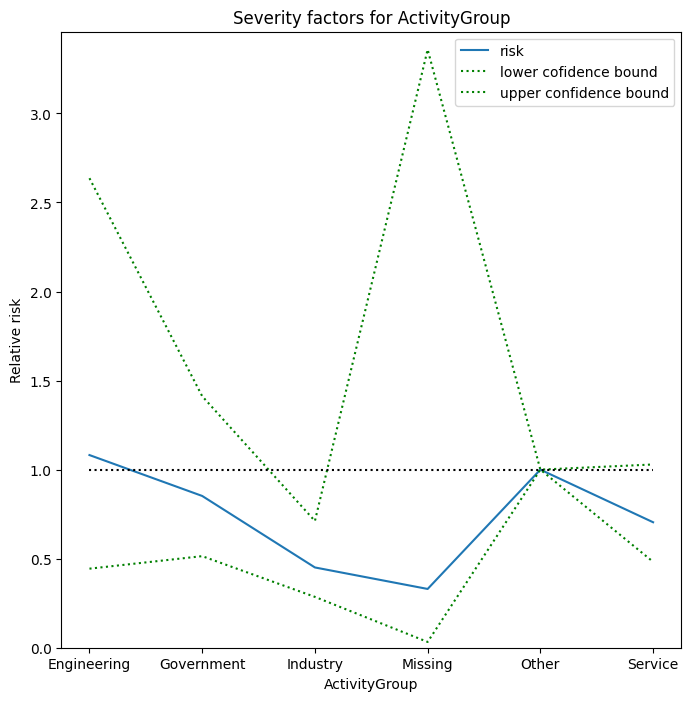

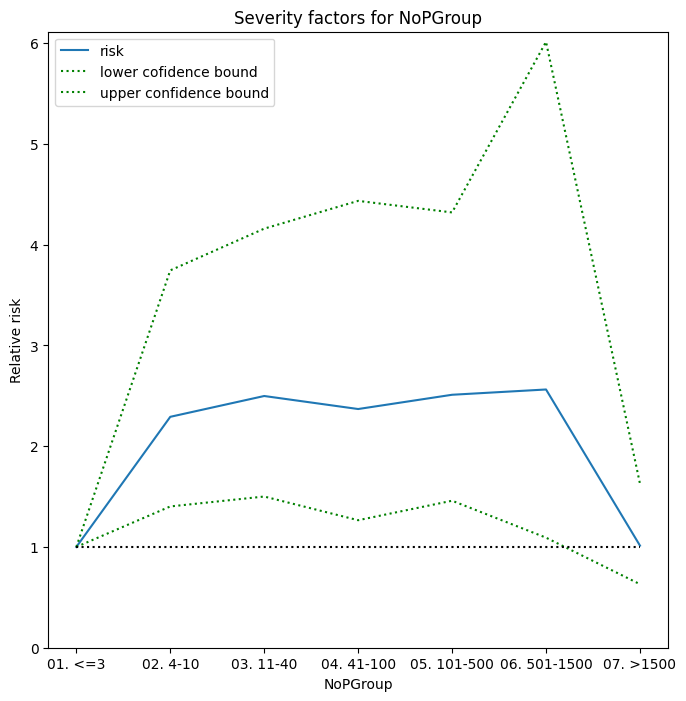

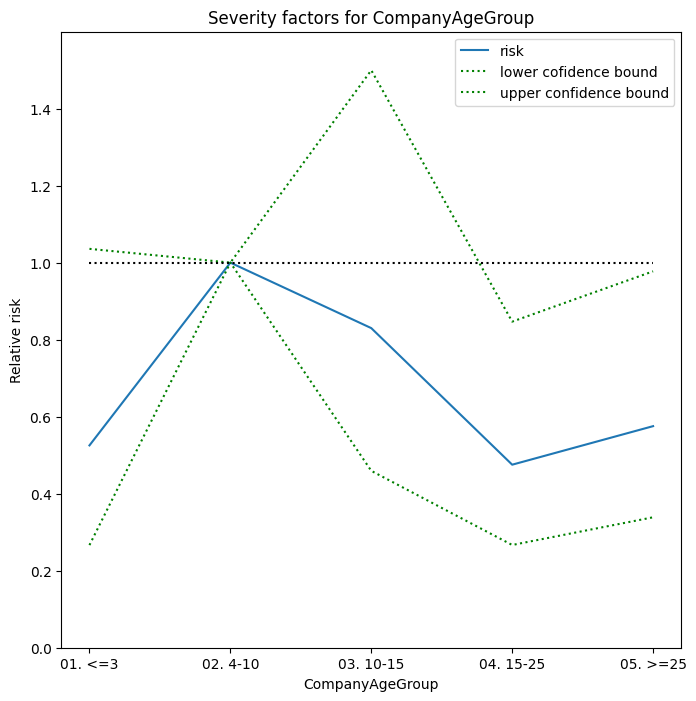

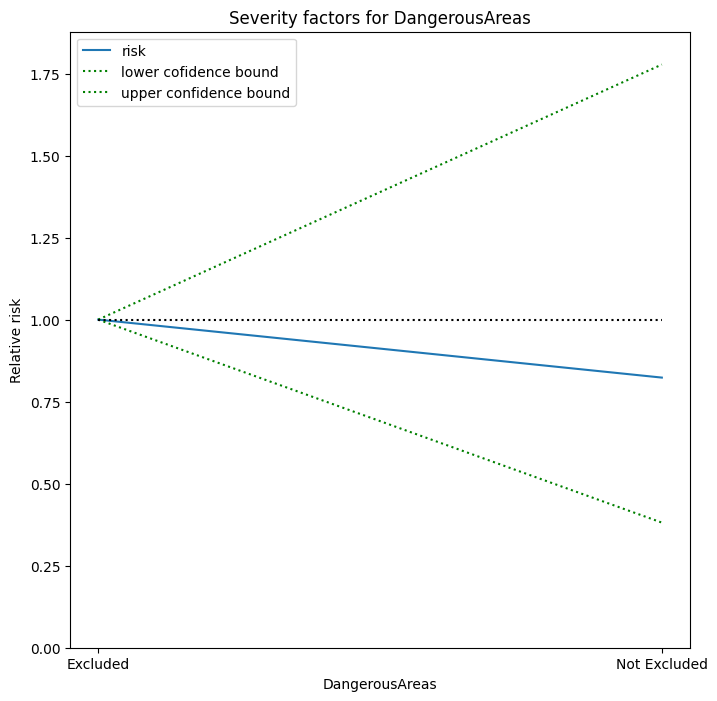

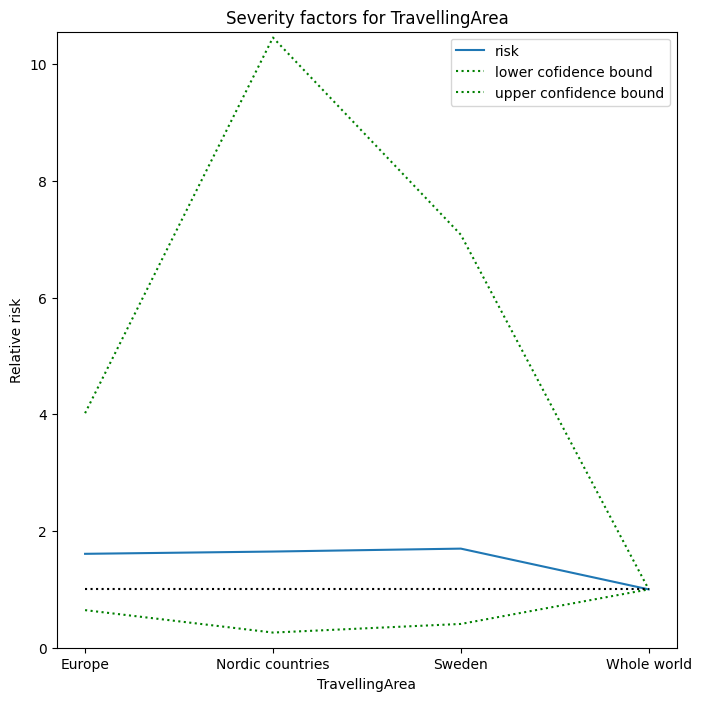

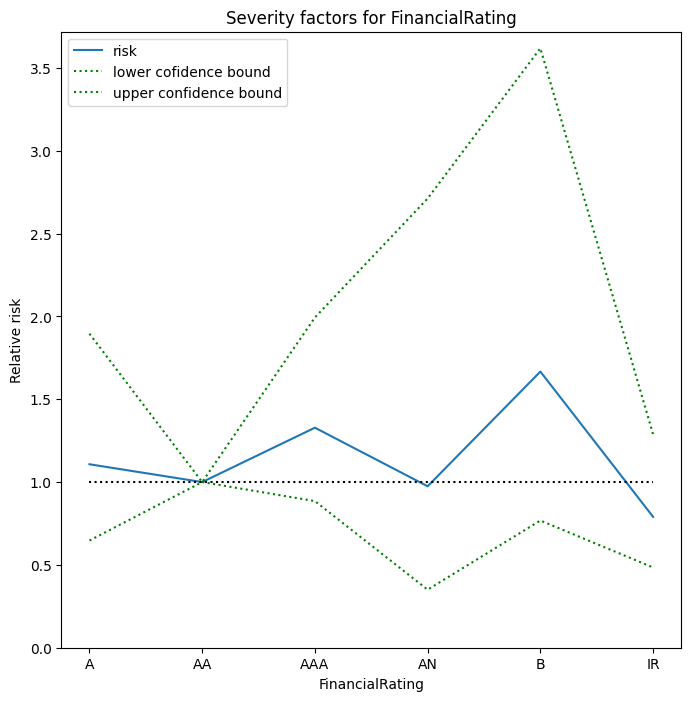

In [26]:
# for var in variables:
#     coefs = get_model_coefficients(severity_model, var)[0]
#     coefs.index.name = var
#     coefs_df = pd.DataFrame(coefs, columns=[f"{var}_severity_factor"])
#     df = df.merge(coefs_df, on=var)

#     plot_model_result(severity_model, var, "Severity")



for var in variablesMORE:
    coefs = get_model_coefficients(severity_modelMORE, var)[0]
    coefs.index.name = var
    coefs_df = pd.DataFrame(coefs, columns=[f"{var}_severity_factor"])
    df = df.merge(coefs_df, on=var)

    plot_model_result(severity_modelMORE, var, "Severity")

## Combine models
When you are satisfied with the outputs from the severity and the frequency models, you should combine them to get the final variable factor, and in the end combine all variable factors to get the final model factor

In [27]:
# For each variable used in the model, the factors from the frequency model and the factors from the severity model are multiplied
for var in variables:
    df[f"{var}_factor"] = df[f"{var}_frequency_factor"] * df[f"{var}_severity_factor"]


for var in variablesMORE:
    df[f"{var}_factor"] = df[f"{var}_frequency_factor"] * df[f"{var}_severity_factor"]

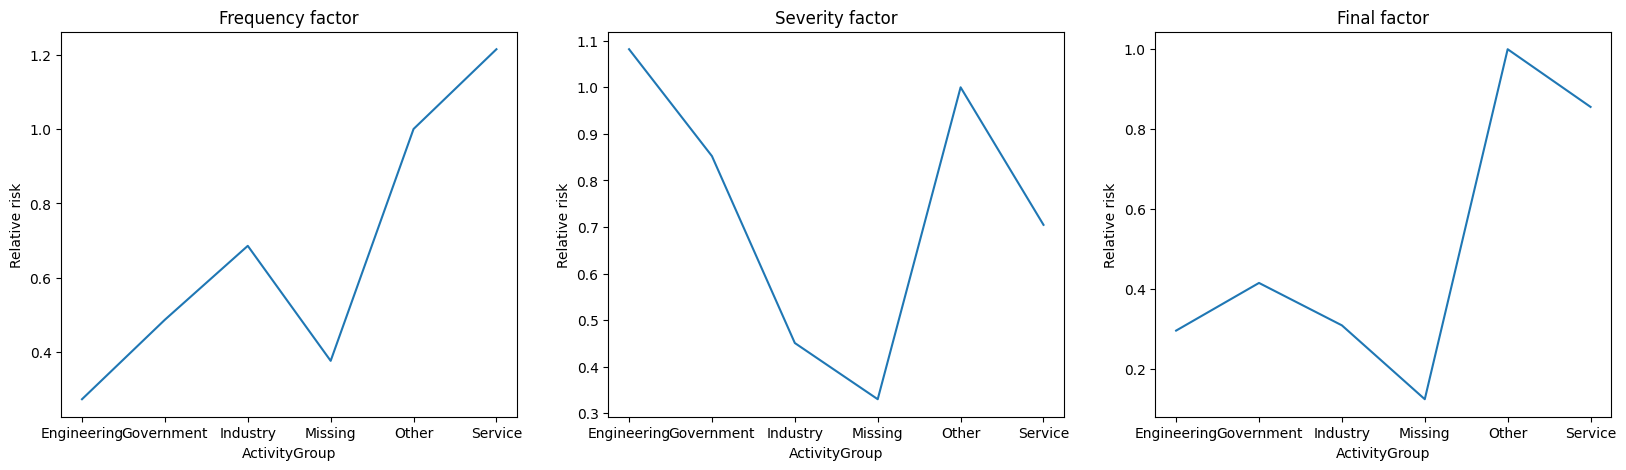

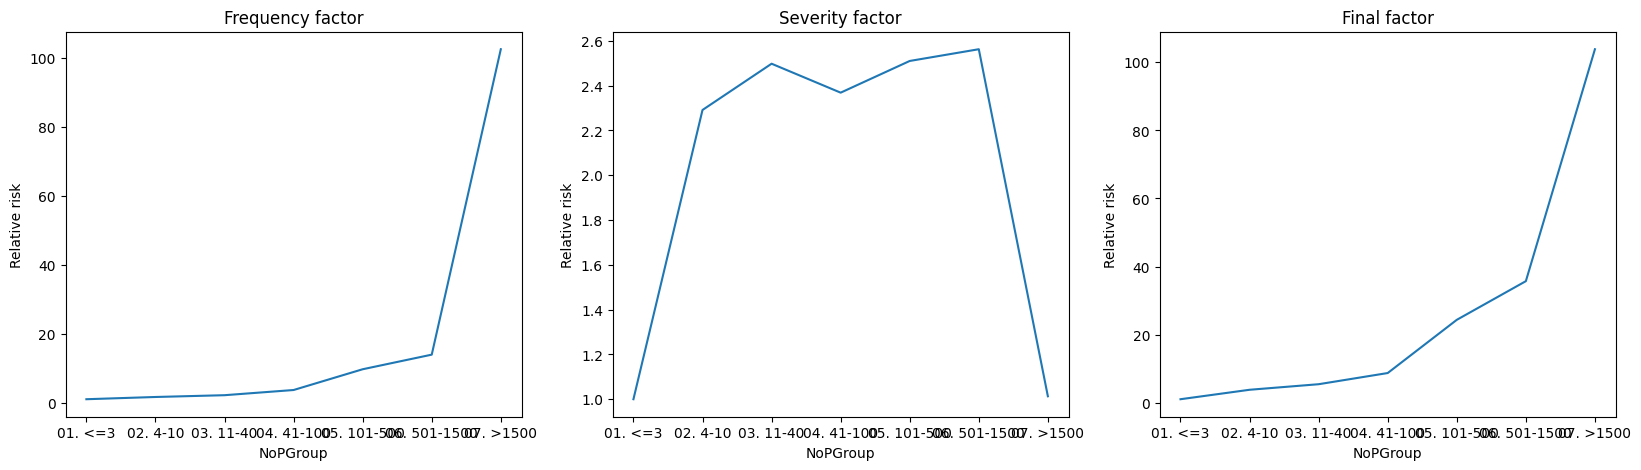

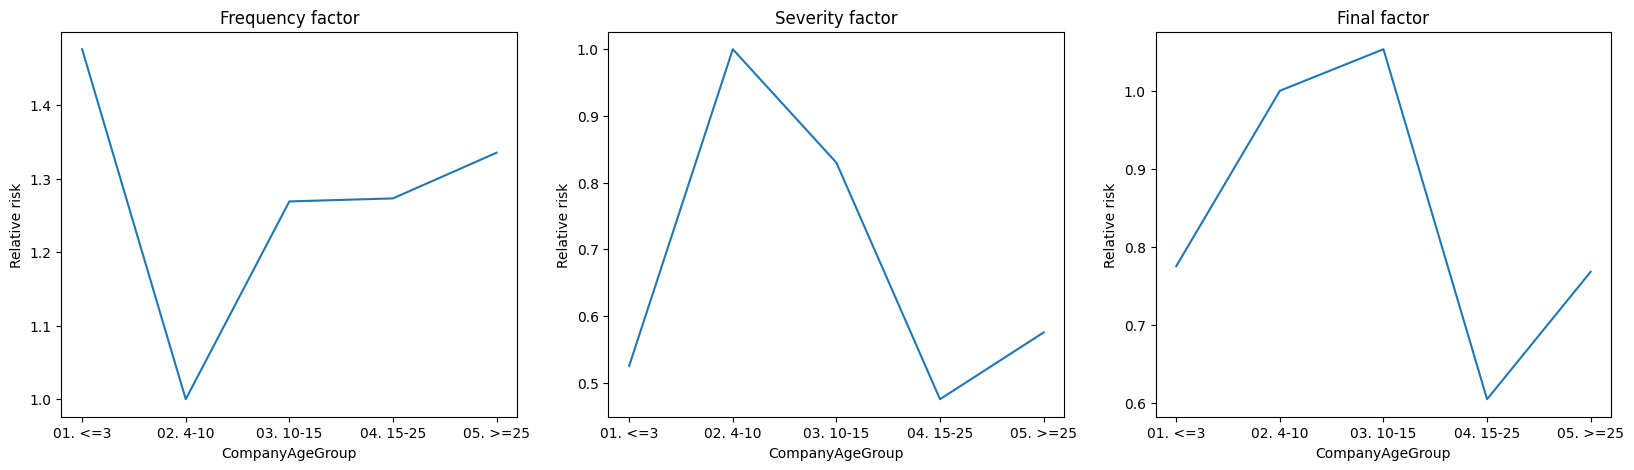

In [28]:
# For each variable used in the model we can plot the factors from the frequency, severity and final variable factor
for var in variables:
    df_plot = (
        df.groupby(
            [var, f"{var}_frequency_factor", f"{var}_severity_factor", f"{var}_factor"]
        )
        .agg({"Duration": "sum"})
        .reset_index()
    )
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.plot(df_plot[var], df_plot[f"{var}_frequency_factor"])
    plt.xlabel(var)
    plt.ylabel("Relative risk")
    plt.title("Frequency factor")
    plt.subplot(132)
    plt.plot(df_plot[var], df_plot[f"{var}_severity_factor"])
    plt.xlabel(var)
    plt.ylabel("Relative risk")
    plt.title("Severity factor")
    plt.subplot(133)
    plt.plot(df_plot[var], df_plot[f"{var}_factor"])
    plt.xlabel(var)
    plt.ylabel("Relative risk")
    plt.title("Final factor")
    plt.show()

In [29]:
# In the end, the factors from each varaible are multiplied to get the final differentiating factor
df.loc[:, "ModelPredictionFactor"] = 1
for var in variables:
    df["ModelPredictionFactor"] *= df[f"{var}_factor"]


df.loc[:, "ModelPredictionFactorMORE"] = 1
for var in variablesMORE:
    df["ModelPredictionFactorMORE"] *= df[f"{var}_factor"]


# Model validation

## Gini validation
For each model we can create a Lorenz curve and get a gini score. The gini score is a good measure of how well the model risk asses the different tariff cells relatively to each other. 

Below there are help functions to
* Create a lorenz curve
* Create a gini score
* Create a gini plot with the help of the two above

In [30]:
def lorentz_curve(x, y, sort_by):
    assert x.shape == y.shape
    df_l2 = (
        pd.DataFrame(data={"x": x, "y": y, "sort_by": sort_by})
        .groupby(["sort_by"], as_index=False)
        .sum()
    )
    x_no_ties = df_l2["x"]
    y_no_ties = df_l2["y"]
    sort_by_no_ties = df_l2["sort_by"]
    sort = np.argsort(sort_by_no_ties)
    x_cumsum = pd.concat(
        [pd.Series([0]), x_no_ties.iloc[sort].cumsum() / x_no_ties.sum()]
    )
    y_cumsum = pd.concat(
        [pd.Series([0]), y_no_ties.iloc[sort].cumsum() / y_no_ties.sum()]
    )
    lorentz = np.trapz(x=x_cumsum, y=y_cumsum)
    diag = np.trapz(x=x_cumsum, y=x_cumsum)
    area_between_curves = diag - lorentz
    return area_between_curves, x_cumsum, y_cumsum


def GiniScore(df, x, y, sort_by):
    oracle_area, oracle_x, oracle_y = lorentz_curve(
        df[x], df[y], df[y] / df[x]
    )  # perfect order
    area, x_cumsum, y_cumsum = lorentz_curve(
        df[x], df[y], df[sort_by]
    )  # prediction order
    gini = area / oracle_area  # area relative perfect area
    return gini


def CreateGiniPlot(df, x, y, i="", figsize=(8, 6)):
    oracle_area, oracle_x, oracle_y = lorentz_curve(df[x], df[y], df[y] / df[x])

    fig = plt.figure(figsize=figsize)

    plt.plot(oracle_x, oracle_y, label=f"Sorted by {y}, perfect model")
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        color="black",
        label="Random baseline " + i + " (Gini {:.3f})".format(0),
    )

    plt.xlabel(
        "Fraction of total "
        + df[x].name
        + "\n"
        + "(ordered by model from safest to riskiest)"
    )
    plt.ylabel("Fraction of total " + df[y].name)

    def AddGiniModel(sort_by):

        area, x_cumsum, y_cumsum = lorentz_curve(df[x], df[y], df[sort_by])
        plt.plot(
            x_cumsum,
            y_cumsum,
            label=f"Sorted by {df[sort_by].name} (NormGini {area/oracle_area:.3f})",
        )

        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(loc="upper left")

        gini = area / oracle_area
        return gini

    return AddGiniModel, fig

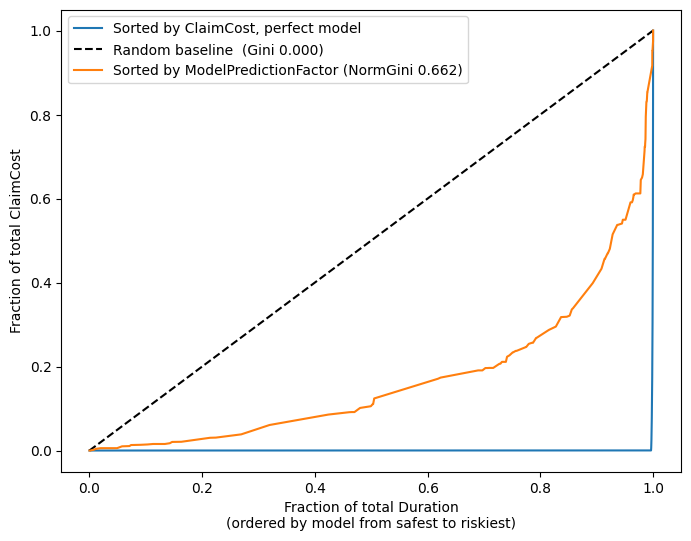

In [31]:
gini, fig = CreateGiniPlot(
    df, "Duration", "ClaimCost"
)  # creates base line and lorenz curve for perfect model (ordered by claim cost which is the actual outcome)
gini_index = gini("ModelPredictionFactor")  # Ordered by your model
plt.show()

### Compare models with gini
It is possible to add two models to the same gini plot to compare them.

Below is an example where a second model (that only prices based on NumberOfPersons - the higher value, the higher price) is added to the gini plot to compare to the first model. 

Note that the NumberOfPersons-model looks best in this case and this can have several reasons. One is that it is more differentiated, since the number of persons are not grouped. When grouping numerical variables, the final factor curve is normally piecewise linear, with the linear parts being interpolations between the model factors. Using the Duration-weighted average value of the variable in each group as the knots for the model factors, try to make an interpolated model and evaluate this instead.

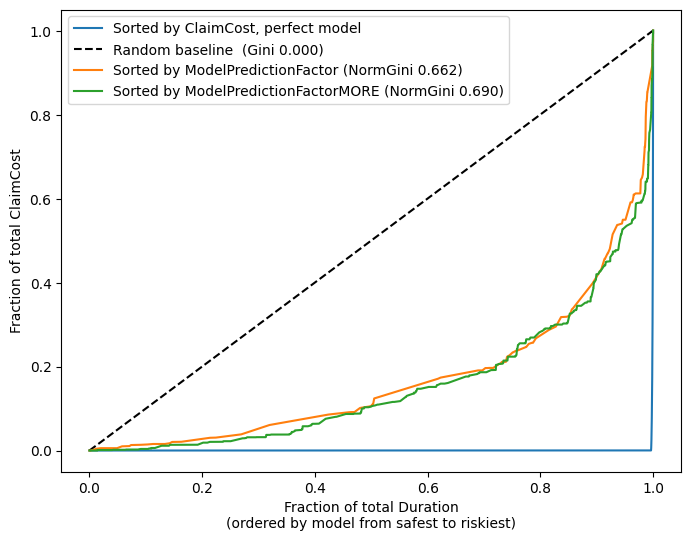

In [32]:
gini, fig = CreateGiniPlot(
    df, "Duration", "ClaimCost"
)  # creates base line and lorenz curve for perfect model (ordered by claim cost which is the actual outcome)
gini_index = gini("ModelPredictionFactor")  # Ordered by your model
gini_index_2 = gini("ModelPredictionFactorMORE")  # Ordered by your second model
plt.show()

## Risk ratio validation
Gini score only takes into account the relative risk between tariff cells. To see if the magnitude is correct, we can use other tests, for example risk ratio validation.

The goal here is to see an even risk ratio between groups, or at least more even than a random model, or that the model you are testing against.

We are here testing between groups in the variables used in the model, but any variables in the data can be used to test on.

Below, we calculate a random claim cost for each customer based on the total claim cost and the duration, and a predicted claim cost based on the model prediction, duration and total claim cost. Based on this set-up the target risk ratio is 1.

Note that above, the gini was better for a model only based on number of persons, but below when assuming a model that prices linearly on number of persons, the risk ratio becomes very uneven between groups, and our glm model performs much better.

In [33]:
# Calculating random claim cost, and claim cost prediction
total_claim_cost = df["ClaimCost"].sum()
total_duration = df["Duration"].sum()
total_model_factor = (df["ModelPredictionFactor"] * df["Duration"]).sum()
total_model_factorMORE = (df["ModelPredictionFactorMORE"] * df["Duration"]).sum()


df["random_claim_cost"] = df["Duration"] * total_claim_cost / total_duration
df["predicted_claim_cost"] = (
    df["ModelPredictionFactor"] * df["Duration"] * total_claim_cost / total_model_factor
)
df["predicted_claim_costMORE"] = (
    df["ModelPredictionFactorMORE"] * df["Duration"] * total_claim_cost / total_model_factorMORE
)

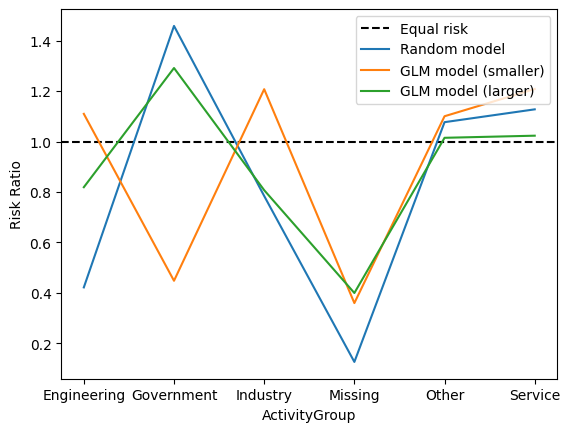

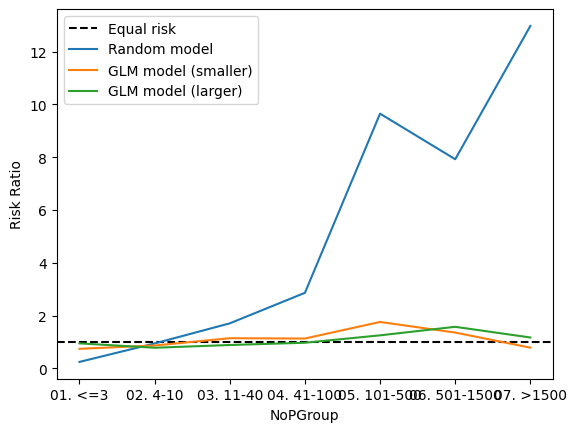

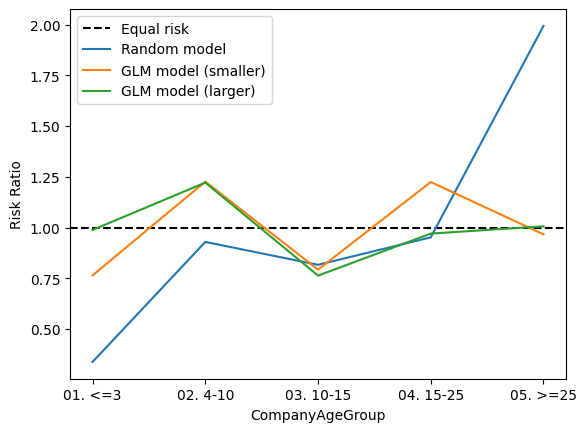

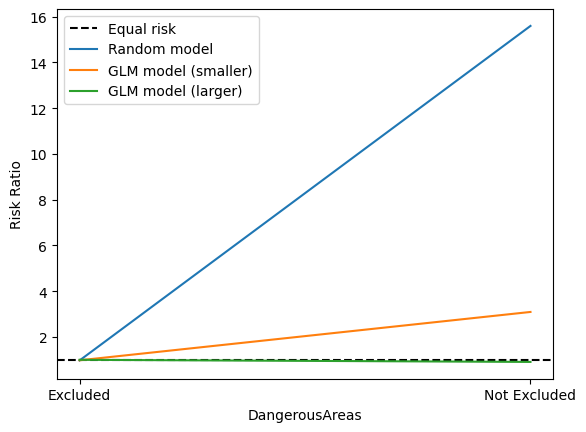

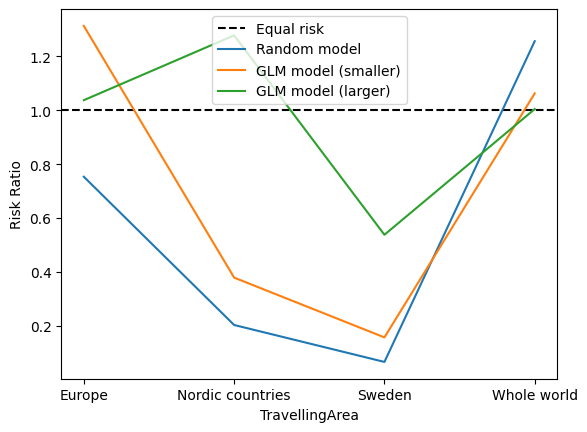

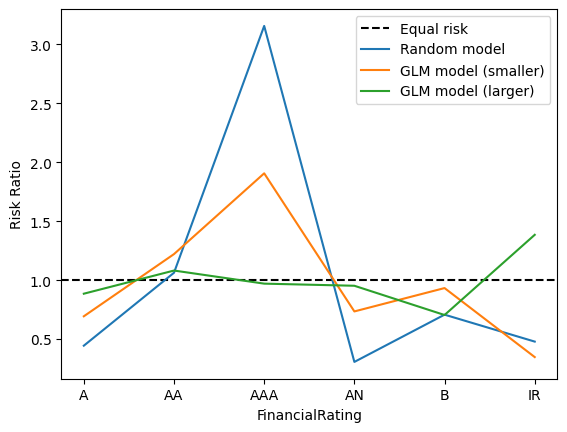

In [34]:
# Aggregating per grouped variable and plotting
agg_dict = {
    "ClaimCost": "sum",
    "random_claim_cost": "sum",
    "predicted_claim_cost": "sum",
    "predicted_claim_costMORE": "sum"
}
for var in variablesMORE:
    df_rr_agg = df.groupby(var).agg(agg_dict)
    fig, ax = plt.subplots()
    ax.axhline(1, color="k", linestyle="dashed", label="Equal risk")
    plt.plot(
        df_rr_agg.index,
        df_rr_agg["ClaimCost"] / df_rr_agg["random_claim_cost"],
        label="Random model",
    )
    plt.plot(
        df_rr_agg.index,
        df_rr_agg["ClaimCost"] / df_rr_agg["predicted_claim_cost"],
        label="GLM model (smaller)",
    )
    plt.plot(
        df_rr_agg.index,
        df_rr_agg["ClaimCost"] / df_rr_agg["predicted_claim_costMORE"],
        label="GLM model (larger)",
    )
    plt.xlabel(df_rr_agg.index.name)
    plt.ylabel("Risk Ratio")
    plt.legend()
    plt.show()

In [35]:
# AIC AND BIC


frequency_model_aic = frequency_model.aic
frequency_model_bic = frequency_model.bic_llf

severity_model_aic = severity_model.aic
severity_model_bic = severity_model.bic_llf

print(f"Frequency Model AIC: {frequency_model_aic}, BIC: {frequency_model_bic}")
print(f"Severity Model AIC: {severity_model_aic}, BIC: {severity_model_bic}")


# risk_model = df['FrequencyModelPrediction'] * df['SeverityModelPrediction']
# risk_model_aic = risk_model.aic

# print(f"Severity Model AIC: {risk_model_aic}")


#print(df["ModelPredictionFactor"])


# `bic_llf` attribute

Frequency Model AIC: 783.8683611978744, BIC: 835.132468191103
Severity Model AIC: 1686.1561023201868, BIC: 1725.238522424032


# Leveling
Now that you have your model factors it is time to set a base level, that is the price that the factors will be multiplied with to get a price.

Here, you need to decide what claim cost to use to calculate the base level for your pricing model. Below is an example where all claim cost in the data set is used. This is not the best way to do it, so think about how you would like to do this.

In [36]:
claim_cost_2023 = df.loc[df["RiskYear"] == 2023, "ClaimCost"]
# print(claim_cost_2023)
tot_claim_cost_2023 = claim_cost_2023.sum()
print(tot_claim_cost_2023)
print(df["ClaimCost"].sum())
# indices_2023 = np.where(df["RiskYear"] == 2023)
# claim_cost_2023 = df["ClaimCost"][indices_2023]
# tot_claim_cost_2023 = claim_cost_2023.sum()
# total_claim_cost = df["ClaimCost"].sum()
target_risk_ratio = 0.9
# total_model_factor = (df["ModelPredictionFactorMORE"] * df["Duration"]).sum()
totModFac2023 = ((df.loc[df["RiskYear"] == 2023, "ModelPredictionFactorMORE"])*(df.loc[df["RiskYear"] == 2023, "Duration"])).sum()
# print("totModFac", total_model_factor)
base_level = tot_claim_cost_2023 / (0.9 * totModFac2023)

df["premium"] = base_level * df["Duration"] * df["ModelPredictionFactorMORE"]
totPremium2023 = df.loc[df["RiskYear"] == 2023, "premium"].sum()
print("hej",df.loc[df["RiskYear"] == 2023, "premium"].sum())
print("premium", df["premium"].sum())
print(base_level)
df

278013.7055506067
3373403.189743284
hej 308904.1172784519
premium 1610138.6018556037
13.162908563127115


,RiskYear,NumberOfPersons,ActivityCode,TravellingArea,DangerousAreas,CompanyAge,FinancialRating,Duration,ClaimCost,NumberOfClaims,...,CompanyAgeGroup_factor,DangerousAreas_factor,TravellingArea_factor,FinancialRating_factor,ModelPredictionFactor,ModelPredictionFactorMORE,random_claim_cost,predicted_claim_cost,predicted_claim_costMORE,premium
0,2020,15.0,G,Whole world,Excluded,29.941135,B,0.3313,0.0,0,...,0.768294,1.0,1.0,1.176191,4.157139,4.889590,16.518280,31.787172,44.673582,21.322876
1,2019,15.0,G,Whole world,Excluded,28.941820,B,0.9994,0.0,0,...,0.768294,1.0,1.0,1.176191,4.157139,4.889590,49.829065,95.889224,134.762383,64.322615
2,2018,15.0,G,Whole world,Excluded,27.942505,B,0.9994,0.0,0,...,0.768294,1.0,1.0,1.176191,4.157139,4.889590,49.829065,95.889224,134.762383,64.322615
3,2023,8.0,M,Whole world,Excluded,32.071182,A,0.9994,0.0,0,...,0.768294,1.0,1.0,0.716300,2.901441,2.078302,49.829065,66.925085,57.280246,27.340086
4,2022,8.0,M,Whole world,Excluded,31.071869,A,0.9994,0.0,0,...,0.768294,1.0,1.0,0.716300,2.901441,2.078302,49.829065,66.925085,57.280246,27.340086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79608,2022,4.0,J,Whole world,Excluded,1.938398,B,0.9994,0.0,0,...,0.775480,1.0,1.0,1.176191,2.505783,2.947280,49.829065,57.798780,81.230206,38.771497
79609,2021,4.0,J,Whole world,Excluded,0.939083,AN,0.9994,0.0,0,...,0.775480,1.0,1.0,0.742074,2.505783,1.859477,49.829065,57.798780,51.249180,24.461435
79610,2020,5.0,J,Whole world,Excluded,14.902104,IR,0.8542,0.0,0,...,1.053213,1.0,1.0,0.217741,3.403214,0.741020,42.589541,67.094163,17.456057,8.331844
79611,2023,2.0,J,Whole world,Excluded,0.005476,IR,0.7804,0.0,0,...,0.775480,1.0,1.0,0.217741,0.663524,0.144477,38.909948,11.951160,3.109363,1.484111


<Axes: >

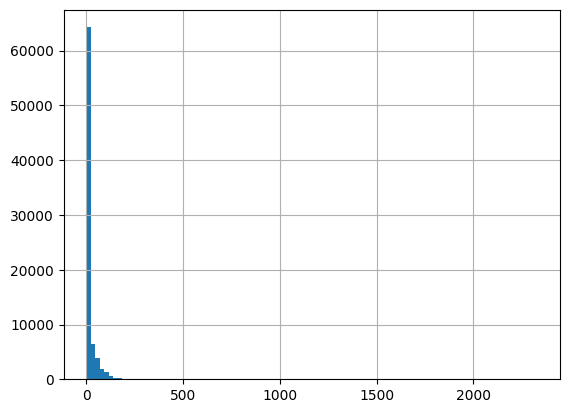

In [37]:
df["premium"].hist(bins=100)
